In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, re

from sklearn.metrics\
import accuracy_score as accuracy,\
        recall_score as recall,\
        precision_score as precision,\
        f1_score as f1,\
        confusion_matrix


from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set_style("white")

# **EDA**

In [5]:
df = pd.read_excel('customer_churn.xlsx')
pd.set_option("display.max_columns", None)

In [6]:
df.shape

(7043, 31)

In [7]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Reason'],
      dtype='object')

In [8]:
df.info(show_counts=True) 
## Null values only exist in the 'Churn Reason' Column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [9]:
df['Churn Value'].value_counts()

0    5174
1    1869
Name: Churn Value, dtype: int64

In [10]:
df.drop(columns=['Count', 'Country', 'State', 'Lat Long', 'Churn Label'], inplace=True)

In [11]:
def categorise(df): 
  df['Gender'] = df['Gender'].map( {'Female': 1, 'Male': 0} ).astype(int)
  
  refactorColumns = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
  for column in refactorColumns:
    df[column] = df[column].map( {'No': 0, 'Yes':1} ).astype(int)
  return df

In [12]:
df = categorise(df)

In [13]:
### 'Nulls' within total charges
df[df['Total Charges'] == ' '].head()

,CustomerID,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason
2234,4472-LVYGI,San Bernardino,92408,34.084909,-117.258107,1,0,1,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,1,Bank transfer (automatic),52.55,,0,NaN
2438,3115-CZMZD,Independence,93526,36.869584,-118.189241,0,0,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,20.25,,0,NaN
2568,5709-LVOEQ,San Mateo,94401,37.590421,-122.306467,1,0,1,0,0,1,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,0,Mailed check,80.85,,0,NaN
2667,4367-NUYAO,Cupertino,95014,37.306612,-122.080621,0,0,1,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,25.75,,0,NaN
2856,1371-DWPAZ,Redcrest,95569,40.363446,-123.835041,1,0,1,0,0,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,0,Credit card (automatic),56.05,,0,NaN


In [14]:
#df[df['Tenure Months'] == 1]    ## Proves customers charged at end of the month?
df['Total Charges'] = df['Total Charges'].replace({' ': 0})
df['Total Charges'] = df['Total Charges'].astype('float64')

In [15]:
## Internet Service, Charges and Newtwork reliability
df[['Internet Service', 'Monthly Charges']].groupby('Internet Service').mean()
df[['Internet Service', 'Monthly Charges']].groupby('Internet Service').count()
df[df['Churn Reason'] == 'Network reliability']['Internet Service'].value_counts()

Fiber optic    67
DSL            30
No              6
Name: Internet Service, dtype: int64

In [16]:
## Contract and Charges
df[['Contract', 'Monthly Charges']].groupby('Contract').mean()

,Monthly Charges
Contract,
Month-to-month,66.398490
One year,65.048608
Two year,60.770413


In [17]:
## Grouping type of payment into manual / automatic
df['Payment Method'] = df['Payment Method'].map( {'Mailed check': 0, 'Electronic check': 0, 'Bank transfer (automatic)' : 1, 'Credit card (automatic)' : 1 } )

#### Demographic of Churn

In [18]:
### df1 --> NO CHURN, Active Members
df1 = df[df['Churn Value'] == 0].copy()
### df2 --> CHURN, Churned Members
df2 = df[df['Churn Value'] == 1].copy()

[]

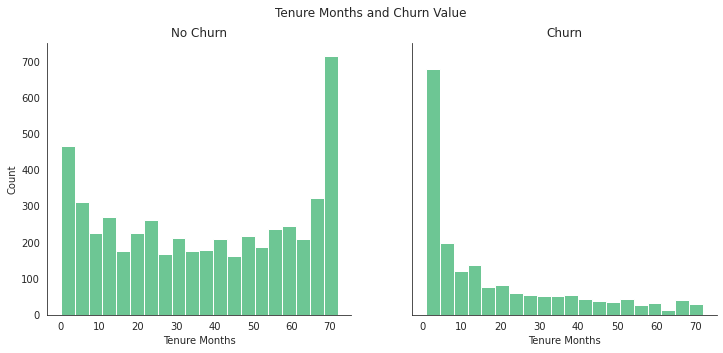

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Tenure Months and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', data=df1, bins = 20, color = 'mediumseagreen' )
axes[0].set_title('No Churn')

# Churn
sns.histplot(ax=axes[1], x='Tenure Months', data=df2, bins = 20, color = 'mediumseagreen')
axes[1].set_title('Churn')

sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

[]

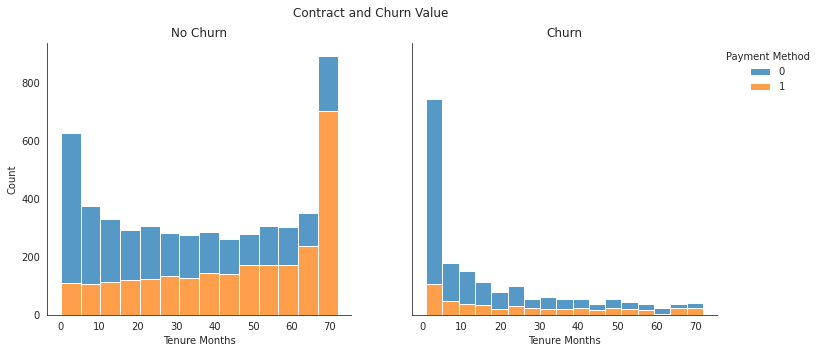

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Contract and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Payment Method', multiple='stack', data=df1)
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)

# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Payment Method', multiple='stack', data=df2)
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)

plt.plot()

[]

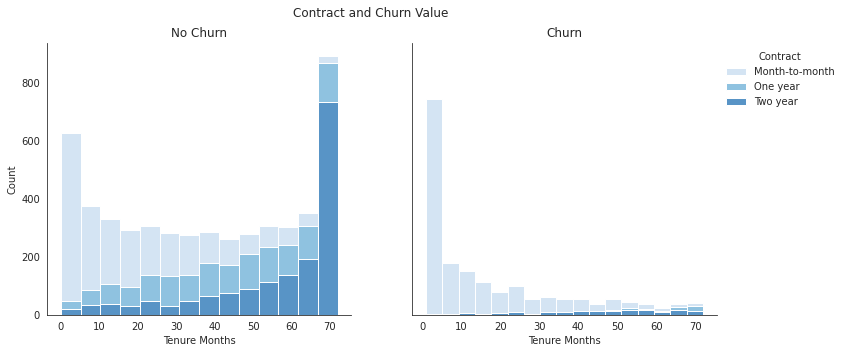

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Contract and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Contract', multiple='stack', data=df1, palette = 'Blues')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)
# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Contract', multiple='stack', data=df2, palette = 'Blues')
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

[]

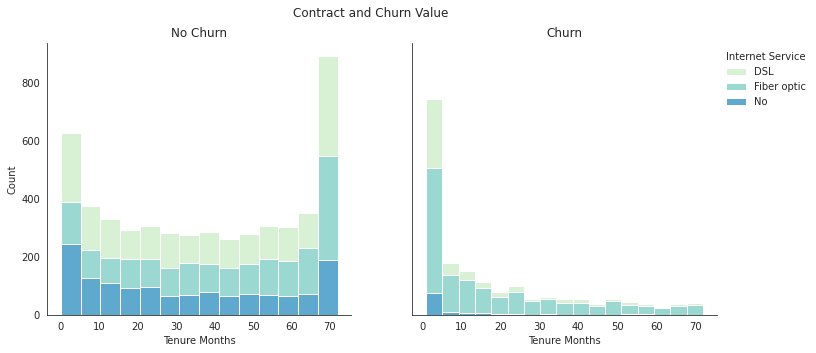

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Contract and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Internet Service', multiple='stack', data=df1, palette ='GnBu')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)


# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Internet Service', multiple='stack', data=df2, palette = 'GnBu')
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)

sns.despine()
plt.plot()

[]

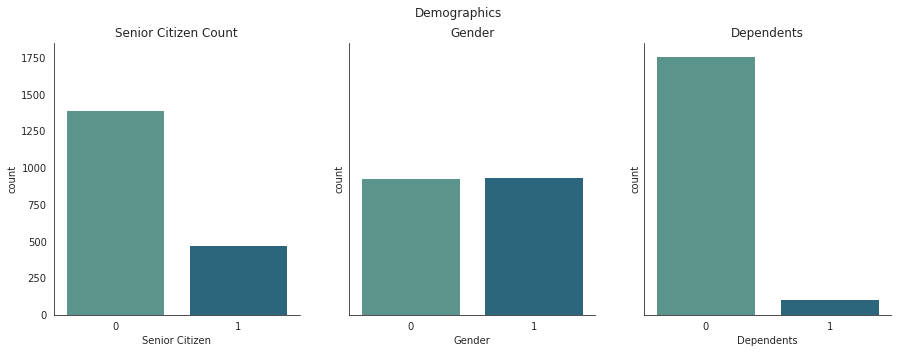

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Demographics')

sns.countplot(ax=axes[0], data = df2, x = 'Senior Citizen', palette='crest')
axes[0].set_title('Senior Citizen Count')

sns.countplot(ax=axes[1], data = df2, x = 'Gender', palette='crest')
axes[1].set_title('Gender')

sns.countplot(ax=axes[2], data = df2, x = 'Dependents', palette='crest')
axes[2].set_title('Dependents')

sns.despine()
plt.subplots_adjust(wspace = 0.2)
plt.plot()

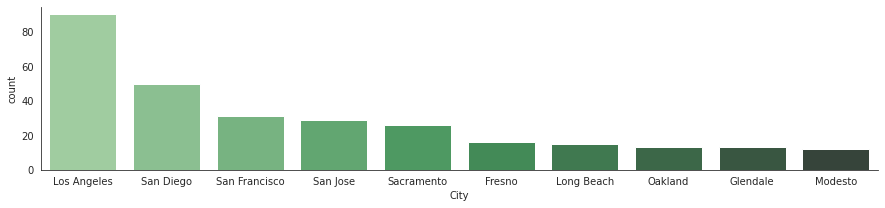

In [24]:
plt.figure(figsize=[15,3])
sns.countplot(data= df2, x = df2['City'],palette="Greens_d", order=df2.City.value_counts().iloc[:10].index )
sns.despine()
plt.show()

In [25]:
citycount = df2[['City','CustomerID']].groupby(['City']).count().sort_values(by = 'City')
citylocation = df2[['City','Latitude','Longitude','Churn Value']].groupby(['City']).mean().sort_values(by = 'City')
cities = citycount.join(citylocation, on='City')

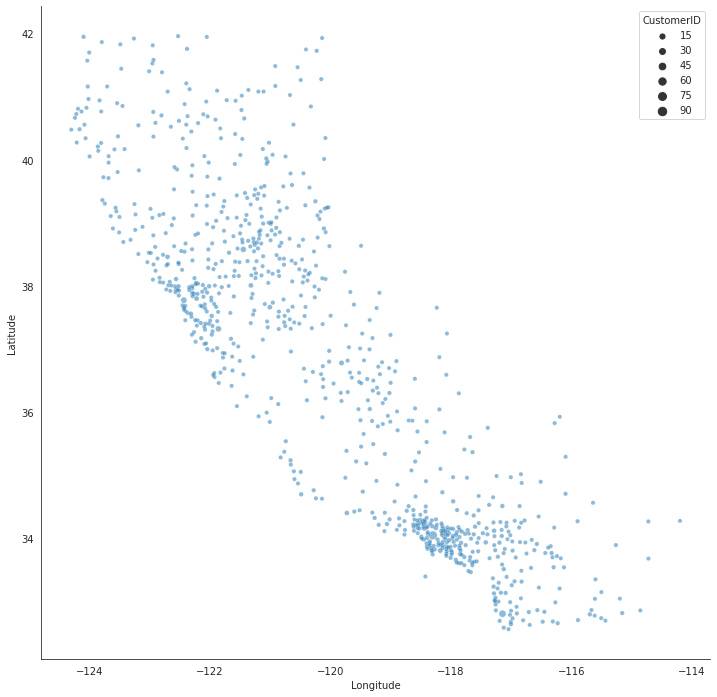

In [26]:
plt.figure(figsize = (12,12))
# plt.scatter('Longitude', 'Latitude', 
#              s='CustomerID',
#              alpha=0.5, 
#              data=cities)
sns.scatterplot(data=cities, x='Longitude', y='Latitude', size='CustomerID', alpha = 0.5)
sns.despine()
plt.show()

[]

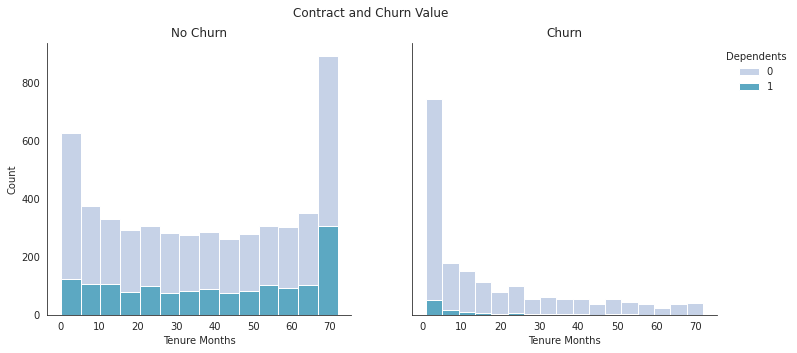

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle('Contract and Churn Value')

# No Churn
sns.histplot(ax=axes[0], x='Tenure Months', hue='Dependents', multiple='stack', data=df1, palette='PuBuGn')
axes[0].set_title('No Churn')
sns.move_legend(axes[0], "upper left", bbox_to_anchor=(2.2, 1), frameon=False)


# Churn
sns.histplot(ax=axes[1], x='Tenure Months', hue='Dependents', multiple='stack', data=df2, palette='PuBuGn' )
axes[1].set_title('Churn')
axes[1].get_legend().remove()
sns.despine()
plt.subplots_adjust(wspace = 0.2)

sns.despine()
plt.plot()

In [28]:
### df3 --> Encoded Churn Reason
df3 = df2.copy()

In [29]:
len(df3['Churn Reason'].unique())    ## 20 Different set of churn reasons

20

In [30]:
churn_reason_lst = df3['Churn Reason'].unique().tolist()
churn_reason_dict = dict(zip(churn_reason_lst, 'bebbbcdddddccceaaaae'))
df3 = df3.replace({"Churn Reason": churn_reason_dict})

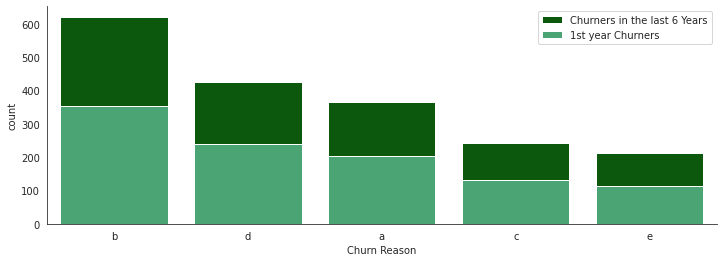

In [31]:
plt.figure(figsize=[12,4])
sns.countplot(data = df3, x='Churn Reason', color = 'darkgreen', order=df3['Churn Reason'].value_counts().index)
sns.countplot(data = df3[df3['Tenure Months'] <= 12], x='Churn Reason', color = 'mediumseagreen', order=df3['Churn Reason'].value_counts().index)
sns.despine()
plt.legend(labels=['Churners in the last 6 Years','1st year Churners'])
plt.show()

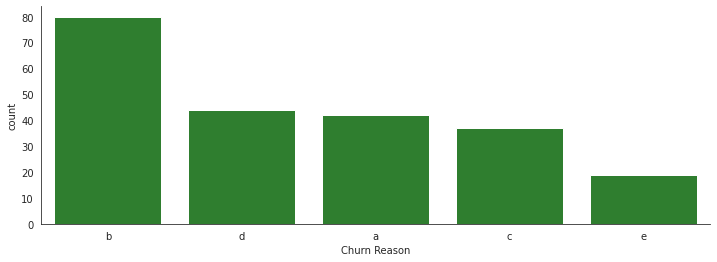

In [32]:
plt.figure(figsize=[12,4])
sns.countplot(data = df3[df3['Tenure Months'] >= 48], x='Churn Reason', color = 'forestgreen', order=df3['Churn Reason'].value_counts().index)
sns.despine()
plt.show()

#### **Product Analysis**

In [33]:
df2['Phone Service'].value_counts(normalize=True)

1    0.909042
0    0.090958
Name: Phone Service, dtype: float64

In [34]:
df2['Internet Service'].value_counts(normalize=True)

Fiber optic    0.693954
DSL            0.245586
No             0.060460
Name: Internet Service, dtype: float64

In [35]:
df[['Phone Service', 'Internet Service', 'Churn Value']].groupby(['Phone Service', 'Internet Service'], as_index=False).mean().sort_values(by='Churn Value', ascending=False)

,Phone Service,Internet Service,Churn Value
2,1,Fiber optic,0.418928
0,0,DSL,0.249267
1,1,DSL,0.166187
3,1,No,0.074050


In [36]:
## NO ONE has no phone service AND no fibre optic
df[(df['Phone Service'] == 0) & (df['Internet Service'] == 'Fibre optic')]

,CustomerID,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason


In [37]:
df[(df['Phone Service'] == 1) & (df['Internet Service'] == 'No')]['Churn Value'].value_counts(normalize=True)

0    0.92595
1    0.07405
Name: Churn Value, dtype: float64

In [38]:
## Fibre Optic broadband not attributed to a Specific City
len(df[df['Internet Service'] == 'Fiber optic']['City'].unique())

1033

In [39]:
## Likewise with DSL
len(df[df['Internet Service'] == 'DSL']['City'].unique())

948

#### Churn Reason Analysis

In [40]:
## DSL not the reason for Network Reliability
df2[df2['Churn Reason']=='Network reliability']['Internet Service'].value_counts()   ## Churn reason analysis

Fiber optic    67
DSL            30
No              6
Name: Internet Service, dtype: int64

In [41]:
len(df2[df2['Churn Reason']=='Network reliability'])  ## of the 103 complaints, 93 different cities, suggests no pattern

103

In [42]:
df['Tech Support'].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [43]:
df['Multiple Lines'].unique()

array(['No', 'Yes', 'No phone service'], dtype=object)

## Model Preparation

In [44]:
def categorise2(df):
  df['Multiple Lines'] = df['Multiple Lines'].map( {'Yes': 1, 'No': 0, 'No phone service' : 0} ).astype(int)

  refactorColumns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']
  for column in refactorColumns:
    df[column] = df[column].map( {'No': 0, 'No internet service': 0,  'Yes':1} ).astype(int)
  return df

In [45]:
df = categorise2(df)

In [46]:
df.head()

,CustomerID,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason
0,3668-QPYBK,Los Angeles,90003,33.964131,-118.272783,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,0,53.85,108.15,1,Competitor made better offer
1,9237-HQITU,Los Angeles,90005,34.059281,-118.307420,1,0,0,1,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,0,70.70,151.65,1,Moved
2,9305-CDSKC,Los Angeles,90006,34.048013,-118.293953,1,0,0,1,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,0,99.65,820.50,1,Moved
3,7892-POOKP,Los Angeles,90010,34.062125,-118.315709,1,0,1,1,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,0,104.80,3046.05,1,Moved
4,0280-XJGEX,Los Angeles,90015,34.039224,-118.266293,0,0,0,1,49,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,1,1,103.70,5036.30,1,Competitor had better devices


In [47]:
## Does grouping the 'No Internet service' affect correlation? Worth making a seperate model?

In [48]:
len(df[(df['Partner']==0) & (df['Dependents']==0)])

3339

In [49]:
df[(df['Partner']==0) & (df['Dependents']==0)]['Senior Citizen'].value_counts(normalize=True)

0    0.832884
1    0.167116
Name: Senior Citizen, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


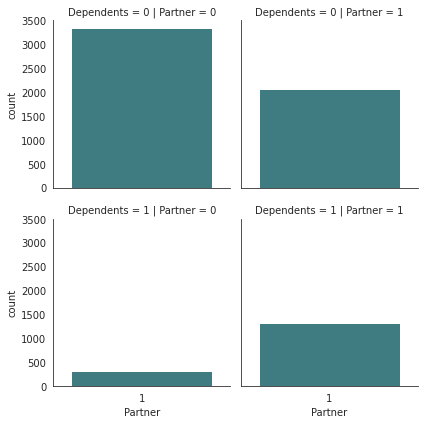

In [50]:
g = sns.FacetGrid(df, col="Partner", row="Dependents")
g.map(sns.countplot, "Partner", palette = 'crest')
plt.show()

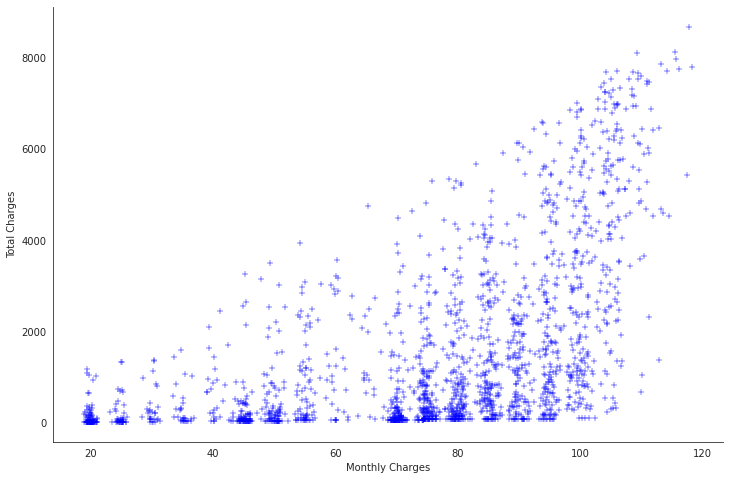

In [51]:
plt.figure(figsize=[12,8])
sns.scatterplot(data=(df[df['Churn Value']==1]), x='Monthly Charges', y='Total Charges', color = 'blue', marker = '+')
sns.despine()
plt.show()

In [52]:
df.head()

,CustomerID,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Reason
0,3668-QPYBK,Los Angeles,90003,33.964131,-118.272783,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,0,53.85,108.15,1,Competitor made better offer
1,9237-HQITU,Los Angeles,90005,34.059281,-118.307420,1,0,0,1,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,0,70.70,151.65,1,Moved
2,9305-CDSKC,Los Angeles,90006,34.048013,-118.293953,1,0,0,1,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,0,99.65,820.50,1,Moved
3,7892-POOKP,Los Angeles,90010,34.062125,-118.315709,1,0,1,1,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,0,104.80,3046.05,1,Moved
4,0280-XJGEX,Los Angeles,90015,34.039224,-118.266293,0,0,0,1,49,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,1,1,103.70,5036.30,1,Competitor had better devices


# **Model**

In [53]:
df_model = df.copy()

In [54]:
df_model.drop(columns=['CustomerID', 'Churn Reason', 'City', 'Zip Code', 'Latitude','Longitude'], inplace=True)

In [55]:
df_model.shape

(7043, 20)

In [56]:
df_model.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,0,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,0,53.85,108.15,1
1,1,0,0,1,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,0,70.70,151.65,1
2,1,0,0,1,8,1,1,Fiber optic,0,0,1,0,1,1,Month-to-month,1,0,99.65,820.50,1
3,1,0,1,1,28,1,1,Fiber optic,0,0,1,1,1,1,Month-to-month,1,0,104.80,3046.05,1
4,0,0,0,1,49,1,1,Fiber optic,0,1,1,0,1,1,Month-to-month,1,1,103.70,5036.30,1


In [57]:
df_model.info(show_counts=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   int64  
 1   Senior Citizen     7043 non-null   int64  
 2   Partner            7043 non-null   int64  
 3   Dependents         7043 non-null   int64  
 4   Tenure Months      7043 non-null   int64  
 5   Phone Service      7043 non-null   int64  
 6   Multiple Lines     7043 non-null   int64  
 7   Internet Service   7043 non-null   object 
 8   Online Security    7043 non-null   int64  
 9   Online Backup      7043 non-null   int64  
 10  Device Protection  7043 non-null   int64  
 11  Tech Support       7043 non-null   int64  
 12  Streaming TV       7043 non-null   int64  
 13  Streaming Movies   7043 non-null   int64  
 14  Contract           7043 non-null   object 
 15  Paperless Billing  7043 non-null   int64  
 16  Payment Method     7043 

In [58]:
feature_cols = list(df_model)
feature_cols.remove('Churn Value')

X = df_model[feature_cols]
y = df_model['Churn Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [59]:
def feature_eng(df):
    df = pd.get_dummies(df, columns = ['Internet Service'], drop_first = True, prefix = 'internet_service')
    df = pd.get_dummies(df, columns = ['Contract'], drop_first = True, prefix = 'contract')
    return df

In [60]:
X_train = feature_eng(X_train)

In [61]:
feature_cols = list(X_train)

In [62]:
## Scaling the Continous Data
# scaler = MinMaxScaler()
# scaler.fit(X_train[['Total Charges','Monthly Charges', 'Tenure Months']]) 
# X_train[['Total Charges','Monthly Charges', 'Tenure Months']] = scaler.transform(X_train[['Total Charges','Monthly Charges', 'Tenure Months']])

In [63]:
scaler = MinMaxScaler()
scaler.fit(X_train[['Monthly Charges', 'Tenure Months']]) 
X_train[['Monthly Charges', 'Tenure Months']] = scaler.transform(X_train[['Monthly Charges', 'Tenure Months']])

In [64]:
X_train.shape

(5634, 21)

In [91]:
feature_cols = ['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Tenure Months',
 #'Phone Service',
 'Multiple Lines',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Paperless Billing',
 'Payment Method',
 'Monthly Charges',
 #'Total Charges',
 #'internet_service_Fiber optic',
 'internet_service_No',
 'contract_One year',
 'contract_Two year']

lr = LogisticRegression(max_iter=300, random_state = 10)
lr.fit(X_train[feature_cols], y_train)
X_train[['notchurnprob', 'churnprob']] = lr.predict_proba(X_train[feature_cols])
X_train['y_pred'] = np.where(X_train['churnprob']>0.42, 1, 0)

In [92]:
def get_results(actual, predicted):
  print(confusion_matrix(predicted, actual))
  print(f'The accuracy of your model is: {accuracy(predicted, actual)}')
  print(f'The recall of your model is: {recall(predicted, actual)}')
  print(f'The precision of your model is: {precision(predicted, actual)}')
  print(f'The F1 of your model is: {f1(predicted, actual)}')

In [93]:
get_results(y_train, X_train['y_pred'])

[[3547  495]
 [ 618  974]]
The accuracy of your model is: 0.8024494142705005
The recall of your model is: 0.6118090452261307
The precision of your model is: 0.6630360789652825
The F1 of your model is: 0.6363933355112709


In [68]:
def checkVIF(X):
    '''Function to calculate the VIF of a dataframe '''
    vif = pd.DataFrame()                
    vif['Features'] = feature_cols      
    vif['VIF'] = [variance_inflation_factor(X[feature_cols].values, i) for i in range(X[feature_cols].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)  
    vif = vif.sort_values(by = "VIF", ascending = False) 
    return vif

In [69]:
checkVIF(X_train)

,Features,VIF
14,Monthly Charges,10.78
4,Tenure Months,7.50
17,contract_Two year,3.44
11,Streaming Movies,2.97
10,Streaming TV,2.87
12,Paperless Billing,2.67
2,Partner,2.62
5,Multiple Lines,2.59
8,Device Protection,2.31
7,Online Backup,2.15


In [70]:
## ROC

In [71]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':X_train['churnprob'], 'Churn_Pred':X_train['y_pred']}).reset_index()
y_train_pred_final.drop(columns=['index'], inplace = True)
y_train_pred_final['CustID'] = y_train.index


In [72]:
y_train_pred_final.head()

,Churn,Churn_Prob,Churn_Pred,CustID
0,0,0.179502,0,2142
1,1,0.555880,1,1623
2,0,0.387897,0,6074
3,1,0.421450,1,1362
4,0,0.041270,0,6754


In [73]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [74]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

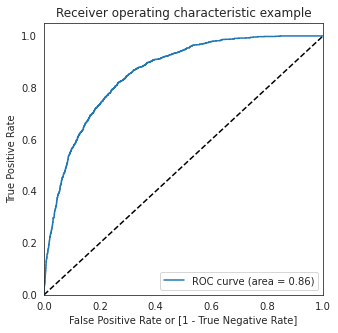

In [75]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [76]:
##Finding Optimal Cutoff Point